# Calculating the phonon modes of MgO


First you will have to manually input the lattice constant of the optimised cell. Please make sure you choose the right value (primitive/conventional). If you don't remember how to specify the geometry for the crystal creation, have a look at the [Optimise the structure](optimisation.ipynb) section. In order to check if the imported value is the correct one you can visualise the cell by using the view() command.

** If the plot does not show up, please run the code again.

** Notice that the dispersion curve is plotted along a this path in the reciprocal space:

    W = 0.5 0.25 0.75
    L = 0.5 0.5 0.5
    G = 0.0 0.0 0.0
    X = 0.5 0.0 0.5
    W = 0.5 0.25 0.75
    
**Notice that the units of the kpoints are normalize.

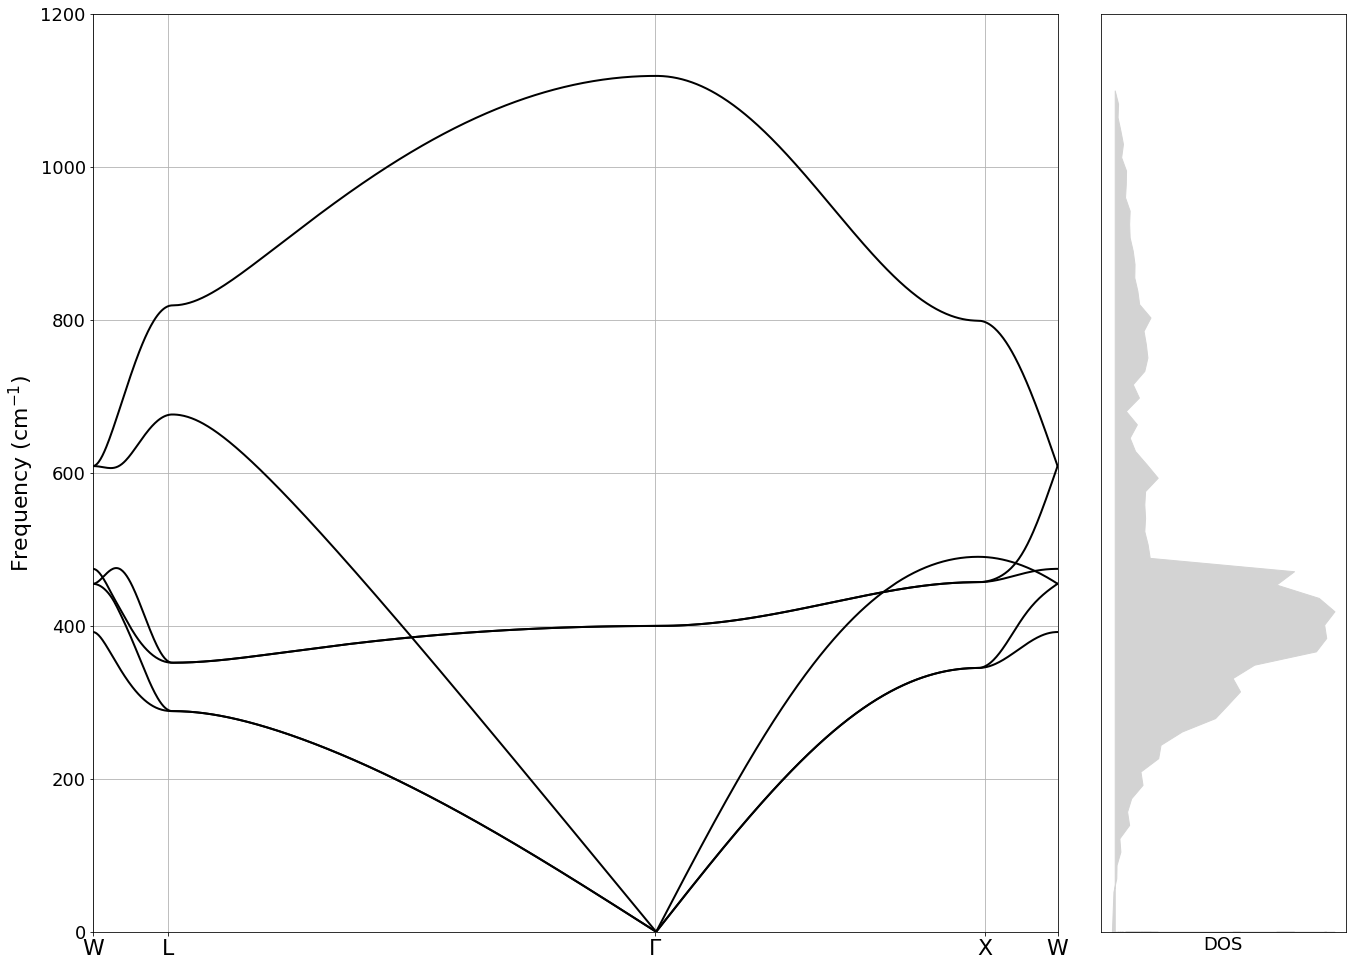

In [2]:
# the import first
import matplotlib.pyplot as plt
import numpy as np
import warnings
import math
from ase.calculators.gulp import GULP
from ase.spacegroup import crystal
from ase.dft.kpoints import ibz_points, bandpath
from ase.visualize import view
from scipy.spatial.distance import pdist


# some settings to make the output look nice
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [20, 15]

# setting the name of the calculation
label = 'mgo_ph'

# The following section is used to define the k point path by using the tools implemented in ASE
# First we need to specify the space group
k_points = ibz_points['fcc']

# this is the name of the k points we want to sample 
k_path = ('W,L,Gamma,X,W')
l = []
L = np.zeros((6, 3))
k_path_coord = ''
tot_path = 0.
# obtain the coordinates of the k points specified above 
for j,i in enumerate(k_path.split(',')):
    l = (k_points['{}'.format(str(i))])
    L[j] = l
    k_path_coord += ("{} to ".format(" ".join(str(x) for x in l)))

# we need to write the string specifying the path for the gulp calculation
k_path_coord = k_path_coord[0:-4]

# calculating the position of the vertical lines for the plot
l_path = [0.]
tot_path = 0.
for i in range(len(L)-2):
    tot_path += float(pdist(L[i:i+2]))
    l_path.append(tot_path)

#INSTERT HERE THE VALUE FOR THE OPTIMISED LATTICE CONSTANT OF THE CONVENCTIONAL CELL
a_opt = 4.212
#creation of the structure and setting of the options
MgO_ph = crystal('MgO',basis=[[0.0,0.0,0.0],[0.5,0.5,0.5]],spacegroup=225,cellpar=[a_opt, a_opt, a_opt, 90, 90, 90],primitive_cell=True)
options = ['shrink 16 16 16','dispersion 1 1000', k_path_coord,'output phon '+label,'output eig '+label]
calc = GULP(label=label ,keywords='conp phon', library='ionic.lib',options=options)
# running the gulp calculation
MgO_ph.calc = calc
MgO_ph.get_potential_energy()

#loading the data for the phonon dispersion from the .disp file
result = np.loadtxt(label+'.disp')
q = np.arange(len(result)/6)
#setting the position of the vertical lines
Q = [0, 78, 580, 920, 995]

# Plot the phonon dispersion
plt.figure(1)
plt.figure(1, (8, 6))
plt.axes([.1, .07, .67, .85])
for i in range(6):
    omega_n = result[i::6,1]
    plt.plot(q, omega_n, 'k', lw=2)

k_path_names = ['W', 'L', '$\\Gamma$', 'X','W']
plt.xticks(Q, k_path_names, fontsize=22)
plt.yticks(fontsize=18)
plt.xlim(q[0], q[-1])
plt.ylim(0, 1200)
plt.ylabel("Frequency ($\mathrm{cm^{-1}}$)", fontsize=22)
plt.grid('on')

#loading the data for the DOS from the .dens file
result_dos = np.loadtxt(label+'.dens')
#plotting the DOS
plt.axes([.8, .07, .17, .85])
plt.fill_between(result_dos[:,1]*100,result_dos[:,0], y2=0, color='lightgrey', edgecolor='k', lw=1)
plt.ylim(0, 1200)
plt.xticks([], [])
plt.yticks([], [])
plt.xlabel("DOS", fontsize=18)
plt.show()

#### Calculating the DOS of MgO

Test the convergence of the DOS by varying the grid size. To do so input in the "grids = " section the N of the NxNxN grids that you want to test. The DOS will be automatically plotted below the cell


Time to calculate the DOS (1x1x1 grid) 0.2969 s
Time to calculate the DOS (2x2x2 grid) 0.2031 s
Time to calculate the DOS (4x4x4 grid) 0.2187 s
Time to calculate the DOS (8x8x8 grid) 0.4219 s
Time to calculate the DOS (16x16x16 grid) 1.8438 s
Time to calculate the DOS (32x32x32 grid) 14.0498 s
Time to calculate the DOS (64x64x64 grid) 203.7188 s


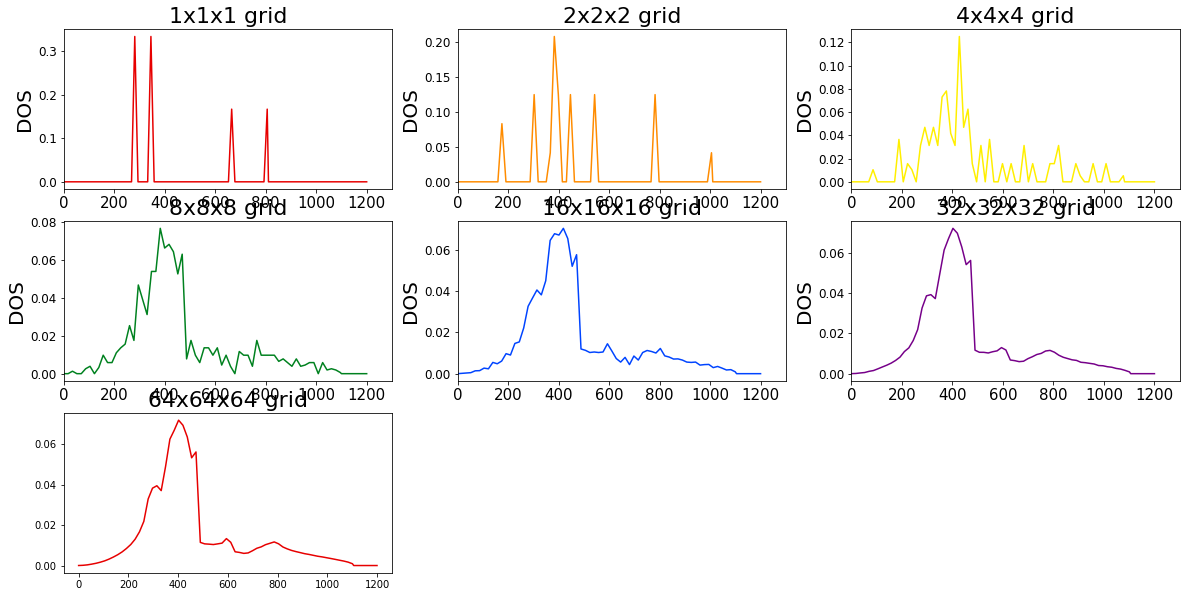

In [8]:
# the imports first, always
%matplotlib inline
from ase.calculators.gulp import GULP
import matplotlib.pyplot as plt
from math import ceil
from ase.spacegroup import crystal
import numpy as np
from time import time

label = 'mgo_dos'
grids = '1 2 4 8 16 32 64'
grids = [int(x) for x in grids.split()]

#Plotting options
plt.rcParams['figure.figsize'] = [20, 10]
c = ['#E70000','#FF8C00','#FFEF00','#00811F','#0044FF','#760089']
# These are the HTML color codes for the rainbow flag. 
# They usually are the symbol of the LGBTQ+ community.
# However, they are used here to point out the fact that Imperial College is against ANY form
# of discrimination (http://www.imperial.ac.uk/equality/). 
# If, for any reason, you want to change these colors you can find the HTML color codes at 
# this webpage (https://htmlcolorcodes.com/).

if len(grids) <= 4:
    nc_plots = 2
else:
    nc_plots = 3

#INSTERT HERE THE VALUE FOR THE OPTIMISED LATTICE CONSTANT
a_opt = 4.212
MgO_dos = crystal('MgO',basis=[[0.0,0.0,0.0],[0.5,0.5,0.5]],spacegroup=225,cellpar=[a_opt, a_opt, a_opt, 90, 90, 90],primitive_cell=True)

# the following is a loop to calculate the DOS for the grid sizes you gave in the input.
# You might want to understand how the loop structure works in order to use it in the
# following parts of the lab
index = 0
times = []
for i in grids:
    b = time()
    index += 1
    label = 'mgo_ph_dos_'+str(i)
    options = ['shrink {} {} {}'.format(i, i, i),'output phon '+label]
    calc = GULP(label=label ,keywords='conp phon', library='ionic.lib',options=options)
    dos_file = label+'.dens'
    MgO_dos.calc = calc
    Energy = MgO_dos.get_potential_energy()
    result = np.loadtxt(label+'.dens')
    result = np.concatenate((result,np.array([[result[-1][0]+5,0.0],[1200,0.0]])),axis = 0)
    plt.ylabel("DOS", fontsize=20)
    #plt.xlabel("Energy", fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=12)
    plt.xlim(0., 1300.)
    plt.subplot(ceil(len(grids)/nc_plots), nc_plots, index)
    plt.title('{}x{}x{} grid'.format(i,i,i),fontsize = 22, y=1)
    plt.plot(result[:,0],result[:,1], '{}'.format(c[(index-1)%6]))    
    times.append(time()-b)
    
for i,j in enumerate(times):
    print('Time to calculate the DOS ({}x{}x{} grid)'.format(grids[i],grids[i],grids[i]),round(j,4),'s')



**Questions:**<br>
1. The density of states for 1x1x1 grid was computed for a single k-point, can you work out which k-point by examining the dispersion curves? Open the output (mgo_ph_dos_1.got) to check if your guess is correct. <br>
    *To open a file use the command %more in a new cell.<br>
<br>
2. How does the density of states vary with grid size? <br>
    - As the grid size increases more and more of the possible vibrations are sampled and more features appear. Which grid size is the minimum for a reasonable approximation to the density of states? When does the DOS stop changing with the grid size? <br>
    - How does the density of states computed at this optimal grid size compare to that computed for smaller and larger grids? <br>
    - How is the density of states related to the dispersion curves? <br>
<br>
3. Plot how the CPU time (time to run the calculation) depends on N and explain the trend.<br>


In [4]:
%more mgo_ph_dos_1.got

In [3]:
times=[0.2969, 0.2187, 0.2656, 0.4375, 2.5764, 13.8988]

In [4]:
N=[1,2,4,8,16,32]

Text(0,0.5,'CPU Time /s')

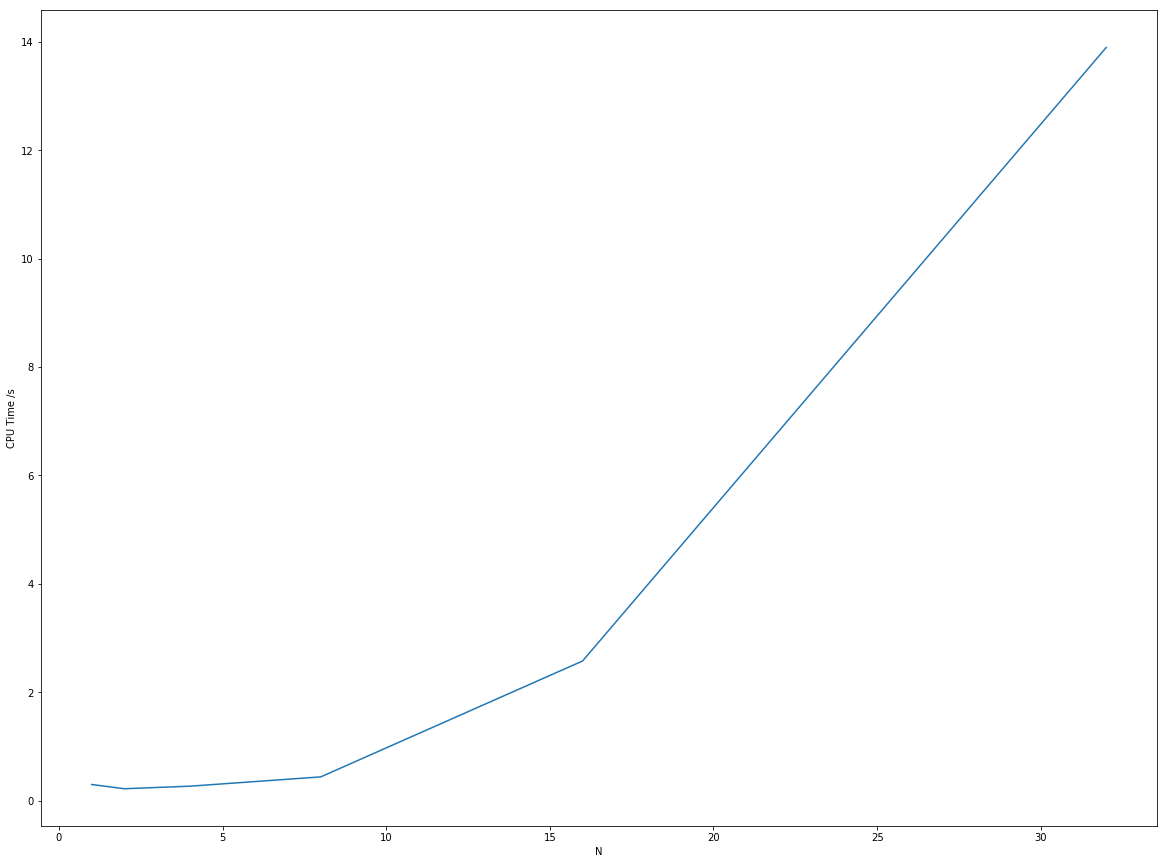

In [7]:
plt.plot(N,times)
plt.xlabel('N')
plt.ylabel('CPU Time /s')